# RL homework 3

-------------------------------


**Name:** Jeremy Dang

**SN:** 17097407

-----------------------------------


**Due date:** *April 8, 2019, 9:00 am*

------------------------------------

## How to Submit

When you have completed the exercises and everything has finsihed running, click on 'File' in the menu-bar and then 'Download .ipynb'. This file must be submitted to Moodle named as **studentnumber_RL_hw3.ipynb** before the deadline above.

# The Assignment

### Objectives

#### Part 1:
You will analyse the learning dynamics of a simple MRP with linear function approximation **[30 pts]**

#### Part 2:
You will use Python to implement several reinforcement learning algorithms and you will answer a few question about the performance of these algorithms **[55pts]**.

#### Part 3:

Analyse optimal values and policies in a small partially observable environment **[15pts]**.



# Setup

## Imports

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import sonnet as snt
import tensorflow as tf
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



## Gridworlds

In [0]:
#@title Implementation
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap = "pink")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()
  
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

A grid world


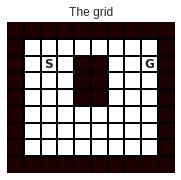


An alternative grid world


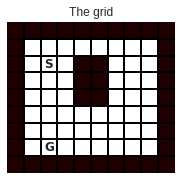


Features (visualised as 9x9 heatmaps) for different locations in the grid
(Note: includes unreachable states that coincide with walls in this visualisation.)


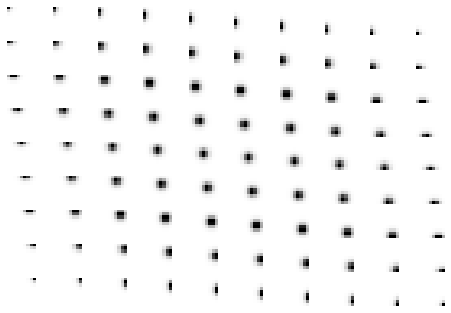

In [0]:
#@title Show gridworlds

# Plot tabular environments
grid = Grid()
alt_grid = AltGrid()
print("A grid world")
grid.plot_grid()
plt.show()
print("\nAn alternative grid world")
alt_grid.plot_grid()
plt.show()

# Plot features of each state for non tabular version of the environment.
print(
    "\nFeatures (visualised as 9x9 heatmaps) for different locations in the grid"
    "\n(Note: includes unreachable states that coincide with walls in this visualisation.)"
)
feat_grid = FeatureGrid()
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)), interpolation='nearest')
  ax.set_xticks([])
  ax.set_yticks([])
plt.show()

## Helpers

In [0]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward
  
map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_rewards(xs, rewards, color):
  mean = np.mean(rewards, axis=0)
  p90 = np.percentile(rewards, 90, axis=0)
  p10 = np.percentile(rewards, 10, axis=0)
  plt.plot(xs, mean, color=color, alpha=0.6)
  plt.fill_between(xs, p90, p10, color=color, alpha=0.3)

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def parameter_study(parameter_values, parameter_name,
  agent_constructor, env_constructor, color, repetitions=10, number_of_steps=int(1e4)):
  mean_rewards = np.zeros((repetitions, len(parameter_values)))
  greedy_rewards = np.zeros((repetitions, len(parameter_values)))
  for rep in range(repetitions):
    for i, p in enumerate(parameter_values):
      env = env_constructor()
      agent = agent_constructor()
      if 'eps' in parameter_name:
        agent.set_epsilon(p)
      elif 'alpha' in parameter_name:
        agent._step_size = p
      else:
        raise NameError("Unknown parameter_name: {}".format(parameter_name))
      mean_rewards[rep, i] = run_experiment(grid, agent, number_of_steps)
      agent.set_epsilon(0.)
      agent._step_size = 0.
      greedy_rewards[rep, i] = run_experiment(grid, agent, number_of_steps//10)
      del env
      del agent

  plt.subplot(1, 2, 1)
  plot_rewards(parameter_values, mean_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Average reward over first {} steps".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)

  plt.subplot(1, 2, 2)
  plot_rewards(parameter_values, greedy_rewards, color)
  plt.yticks=([0, 1], [0, 1])
  plt.ylabel("Final rewards, with greedy policy".format(number_of_steps), size=12)
  plt.xlabel(parameter_name, size=12)
  
def random_policy(q):
  return np.random.randint(4)

def epsilon_greedy(q_values, epsilon):
  if epsilon < np.random.random():
    return np.argmax(q_values)
  else:
    return np.random.randint(np.array(q_values).shape[-1])

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  plt.hold('on')
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

def plot_greedy_policy_v2(grid, pi):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(pi, axis=2)
  grid.plot_grid()
  plt.hold('on')

  h, w = grid._layout.shape
  for y in range(2, h-2):
    for x in range(2, w-2):
      action_name = action_names[greedy_actions[y-2, x-2]]
      plt.text(x, y, action_name, ha='center', va='center')

# Part 1: Linear Function Approximation

## Q1

We will analyze a simple Markov reward process (an MRP is an MDP without actions or, equivalently, with just 1 action in each state).  

- It consists of two states. 
- The reward is zero everywhere. 
- When we are in state $s_0$, we always transition to $s_1$. 
- If we are in state $s_1$, there is a probability $p$ of terminating, after which the next episode starts in $s_0$ again.  With a probability of $1 - p$, we transition from $s_1$ back to itself again. 
- The discount is $\gamma = 1$ on non-terminal steps.




#### [1pt] Question 1.1
What is the optimal value in each state?

>- Optimal value at each state $(s_0,s_1)$ is $0$ this is because the Reward is zero everywhere and by writing out the solution to the bellman equation:
 
>- Need to solve for $ v_i = v^{\pi}(s_i) \implies (\mathbb{I}_2 - \gamma{P}_{2\times2})\mathbf{v} = \mathbf{R} $

>- Where $P$ is the transition matrix.
 
$$ \mathbf{v} = (\mathbb{I}_2 - \gamma{P}_{2\times2})^{-1}\mathbf{R} \implies  \mathbf{v} = (\mathbb{I}_2 - {P}_{2\times2})^{-1}\mathbf{0}_{2\times1}  = \mathbf{0}_{2\times1} $$


#### [1pt] Question 1.2
Instead of a tabular representation, consider a single feature $\phi$, which takes the values $\phi(s_0) = 1$ and $\phi(s_1) = 3$.  Now consider using linear function approximation, where we learn a value $\theta$ such that $v_{\theta}(s) = \theta \times \phi(s) \approx v(s)$, where $v(s)$ is the true value of state $s$.  What is the optimal value of $\theta$?

> Reading the "Deep Reinforcement Learning and the Deadly Triad" paper by Hasselt et al shows that even with this transformation the optimal value of $\theta = 0$ 

### Online updates

We now assume we generate data sampling from the MRP, starting each episode in state $s_0$ and following the environment's dynamics until episode termination. Updates are then performed online on each newly generated transition.

#### [5pts] Question 1.3
Suppose $\theta_0 = 1$, and suppose we update this parameter online with TD(0) with a step size of $\alpha = 0.1$.  What is the expected value of $\mathbb{E}[ \theta_T ]$ if we step through the MRP until it terminates after the first episode, as a function of $p$?  (Note that $T$ is random.)

>- The update $\theta$ from $s_0$ $\rightarrow$ $s_1$ with probability $1$. This step is always determinstic and is not random.

$$ \Delta\theta_{s_o \rightarrow s_1} = \alpha(R_{t+1} + \gamma v_{\theta}(s_{t+1}) - v_{\theta}(s_{t}))\nabla v_{\theta}(s_{t})  $$


$$ \Delta\theta_{s_o \rightarrow s_1} = \alpha(R_{1} + \gamma v_{\theta}(s_{1}) - v_{\theta}(s_{0}))\nabla v_{\theta}(s_{0})  $$

$$ \Delta\theta_{s_o \rightarrow s_1} = \alpha(0 + 3\theta\gamma - 1\theta) $$

$$ \Delta\theta_{s_o \rightarrow s_1} = \alpha\theta(3\gamma - 1) $$


>- The Update $\theta$ from $s_1$ $\rightarrow$ $s_1$ with probability $1-p$

$$ \Delta\theta_{s_1 \rightarrow s_1} = \alpha(R_{t+1} + \gamma v_{\theta}(s_{1}) - v_{\theta}(s_{1}))\nabla v_{\theta}(s_{1}) $$

$$ \Delta\theta_{s_1 \rightarrow s_1} = \alpha(0 + 3\gamma \theta - 3\theta)3 $$

$$ \Delta\theta_{s_1 \rightarrow s_1} = 9\alpha\theta(\gamma  - 1) $$


>-  Finally the update $\theta$ from $s_1$ $\rightarrow$  $TERMINATION$ with probability $p$ is:

$$ \Delta\theta_{s_1 \rightarrow TERMINATION} = \alpha(0 + 0 - v_{\theta}(s_{t_1}))\nabla v_{\theta}(s_{1}) $$

$$ \Delta\theta_{s_1 \rightarrow TERMINATION} = \alpha(0 + 0 - 3\theta)3 $$

$$ \Delta\theta_{s_1 \rightarrow TERMINATION} = -9 \alpha \theta $$

>- With these updates listed, we can now proceed to find $\theta_{T}$ for some arbitrary $T$. Consider $\theta_{1}$ given $\theta_{0} =1$, this means that we update from $s_{0}$ $\rightarrow$ $s_{1}$

$$ \theta_{1} = \theta_{0} + \Delta\theta_{s_o \rightarrow s_1}  $$

$$ \theta_{1} = 1 + \alpha\theta(3\gamma - 1)  $$


>- Updating $\theta_{2} \implies s_1 \rightarrow s_1$. That is a second update implies we transition from $s_1$ to $s_1$ with probability $1-p$.

$$ \theta_{2} = \theta_1 + \Delta\theta_{s_1 \rightarrow s_1} $$

$$ \theta_{2} = \theta_1 +  9\alpha\theta_{1}(\gamma  - 1) $$

$$ \theta_{2} = \theta_1(1 + 9\alpha(\gamma -1)) $$


>- Now I will show what $\theta_{3}$ is to illustrate a recursive pattern that occurs:

$$ \theta_{3} = \theta_{2} + \Delta\theta_{s_1 \rightarrow s_1}  $$

$$ \theta_{3} = \theta_1[1 + 9\alpha(\gamma -1)] + 9\alpha\theta_{2}(\gamma  - 1)  $$

$$ \theta_{3} = \theta_1[1 + 9\alpha(\gamma -1)] + 9\alpha\theta_1[1 + 9\alpha(\gamma -1)](\gamma  - 1)  $$

$$ \theta_{3} = \theta_1[\{1 + 9\alpha(\gamma -1)\} + 9\alpha\{1 + 9\alpha(\gamma -1)\}(\gamma  - 1)]  $$

$$ \theta_{3} = \theta_1\{1 + 9\alpha(\gamma -1)\}\{1 + 9\alpha(\gamma  - 1)\}  $$

$$ \theta_{3} = \theta_1(1 + 9\alpha(\gamma  - 1))^2  $$

>- For some time $t$ we therefore have the recursive relation:

$$ \theta_{t} = \theta_1(1 + 9\alpha(\gamma  - 1))^{t-1}  $$

>- Therefore the generalised form with termination is, this is obtained by combining the above generalised form (also reduce time step due to terminating) and doing the update $s_1 \rightarrow TERMINATION$ :

$$ \theta_{T} = (1-9\alpha)\theta_1(1 + 9\alpha(\gamma  - 1))^{t-2} $$

>-  By substituting our values for $\gamma = 1$ and $\alpha = 0.1$ we have:

$$ \theta_{T} = (1-9\times 0.1)\theta_1[(1 + 9\times 0.1(1  - 1))^{t-2}] $$

$$ \theta_{T} = (1-0.9)[(1 + 0.1\times 1(\{3\times 1\} - 1))](1)^{t-2} $$

$$ \theta_{T} = (0.1)(1 + \{0.1\times 1\times 2\}) $$

$$ \theta_{T} = 0.1\times 1.2 $$

$$ \theta_{T} = 0.12 \implies \mathbb{E}(\theta_{T}) = 0.12 \times p^{0}$$


#### [5pts] Question 1.4
If $p=0.2$, how many episodes does it take, starting from $\theta_0 = 1$, until $| v(s) - \mathbb{E}[v_{\theta}(s)] | < 0.1$ for all $s$, where the expectation is over the expected updates to $\theta$?

>- We have $\mathbb{E}[v_{\theta}(s)] = \mathbb{E}(\theta \times \phi(s))$ and $v(s) = 0 $

>- Taking expectation on the RHS gives us:

$$  \mathbb{E}(\theta \times \phi(s)) =  \mathbb{E}(\theta)\mathbb{E}(\phi(s)) = 0.12 \times 3 $$

>- Since $\theta$ is constant continually iterating for the condition $|  0.12^{t} \times 3 | < 0.1$. Therefore after 2 episodes we have satisfied the condition.


#### Changing the data distribution
Now suppose we use TD to update the parameters, but instead of using the online data, we assume we can actively sample a transition from any of the two states, and on each training step we sample a transition from the first state with probability $\beta$ or instead a transition from the second state with probability $1-\beta$.

#### [3pts] Question 1.5

What is the value of $\mathbb{E}[\theta_n]$, as a function of $n$, $p$ and $\beta$?

>- Taking the above updates from Q1.3 and substituting the appropriate values for $\gamma$ and $\alpha$:

$$ \Delta\theta_{s_o \rightarrow s_1} = 0.2\theta $$

$$ \Delta\theta_{s_1 \rightarrow s_1} = 0 $$

$$ \Delta\theta_{s_1 \rightarrow TERMINATION} = -0.9 \theta $$


>- Consider the sampling process, we can either start at $s_0$ or at $s_1$ with probability $\beta$ and $1-\beta$ respectively. If we actually started at $s_0$ then we know with probability $1$ we move to $s_1$. Therefore the expected reward given that we start at $s_0$ is the following:

$$ \mathbb{E}(v_{s_0} | S = s_0) = 1 + 0.2(1) = 1.2 $$

>- Similarly if we start at $s_1$ we get the following by summing up cases if we if we terminate or stay in $s_1$ with their respective probabilities and apply the definition of $\mathbb{E}$ :

$$ \mathbb{E}(v_{s_1} | S = s_1) = p\times (1-0.9) + (1-p)(1+0.9(1-1)) =  p - 0.9p + 1 - p = 1 - 0.9p $$

>- To compute our quantity, we can model $\mathbb{E}(\theta_n)$  as a $Binomial$ distribution because in each time step $n$ we have a probability of $\beta$ and $1-\beta$ of sampling $s_0$ and $s_1$ respectively. Mathematically we then write this as $ \theta_n \sim Bin(n, \beta)  $  and therefore the PMF is :

$$ \mathbb{E}(\theta_n) = \sum_{k}^{n} {n \choose k}\beta^{k}(1.2)^{k} (1-\beta)^{n-k}(1-0.9p)^{n-k} = \sum_{k}^{n} {n \choose k}(1.2\beta)^{k} ((1-\beta)(1-0.9p))^{n-k} $$

>- Then using properties of binomial expansion we have the final expression in terms of $n$, $p$, $\beta$ as required:

$$ \mathbb{E}(\theta_n) = (1.2\beta + [(1-\beta)(1-0.9p)]^{n} $$



#### [5pts] Question 1.6

When does $\theta$ converge to the true solution? Give your answer as a function of $\beta$ and $p$.

>- In this scenario, to get $\theta$ to converge to the true solution we need to sample $\beta \propto p$ since we are sampling transitions these may be independent of how frequent the agent visits a state and as a result this proportionality needs to exist to obtain convergence (Proven by [Tsitsiklis & Van Roy, 1997] ). In our case since we have $\mathbb{E}(\theta_n)$ we can make some inferences here about it's convergence.


$$ (1.2\beta + [(1-\beta)(1-0.9p)]^{n} \leq 1.2 \text{ } \text{By putting in largest values of } \gamma \text{, } \beta$$

$$ (1.2\beta + [(1-\beta)(1-0.9p)]  \leq 1 \text{ } \text{for } n > 1 $$

$$ (1 + 0.2\beta + 0.9p(\beta-1) \leq 1 $$

$$ (0.2\beta + 0.9p(\beta-1)) \leq 0 $$

>- Solving for either $\beta$ or $p$ we get the following proportionality and applying properties of a probability that is $\beta, p \in [0,1]$ we can find out values for $\beta, p$:

$$ \beta \leq \frac{0.9p}{0.2 + 0.9p} =  \frac{9p}{2 + 9p} \in [0, 0.82] $$


#### [5pts] Question 1.7

Why doesn't it always converge?

>- Because the states are being randomly sampled with probablily$\beta$ and $1-\beta$ which is another distribution independent of the dynamics of the MRP. [Tsitsiklis & Van Roy, 1997] Explains this in more depth and demonstrates that online sampling "that do not sample states with the frequencies natural to the Markov chain and, as a result, do not generally converge".  

>- We also have properties of the "Deadly Triad" since we are using Function approximation, Bootstrapping (TD methods) and off-policy training (training on a distribution of tranitions other than that produced by target policies). The combination of the three can therefore lead to divergence this was shown by Sutton et al. See page 215 in the Sutton book, Reinforcement Learning: An introduction. Especially with our dynamics - is a highlighted case that can diverge.

#### [5pts] Question 1.8
Describe one way to change the algorithm to obtain convergence of $\theta$, for any $p$, without changing the sampling or the value function (which should remain as $v_{\theta}(s) = \theta \times \phi(s)$).  Note that the sampling is not sequential, so for instance you cannot add 'memory of the previous state', or anything like that.

> An example change is to employ a $\gamma < 0.5$ i.e Choose a $\gamma$ that is strictly smaller than $0.5$ assuming our existing system with linear function approximation are the above values in the previous question. But realistically choose a sufficiently small $\gamma$ will do, such that $\sum_{i}^{\infty}\gamma^{i} $ converges due to properties of a geometric series. This was shown by [Tsitsiklis & Van Roy, 1997] and is a suitable method to obtain convergence.


# Part 2: Planning

## 2.1: Implement Agents

We are going to implement 5 agent:
- Online Tabular Q-learning
- Tabular Experience Replay
- Tabular Dyna-Q (with a Tabular model)
- Experience Replay with linear function approximation
- Dyna-Q with linear function approximation (with a linear model)

All agent you implement in this section must share the agent interface

#### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get such initial observation by instatiating an environment (e.g., `grid = Grid()`), and then calling `grid.get_obs()`. All agents should be in pure Python - do not use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.

#### `step(self, reward, discount, next_observation)`:
The step should update the internal values, and return a new action to take. When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function. Note that to perform updates within the `step` function you typically need to store the previous state and/or action: you may set such previous action to 0 in the constructor for consumption in the first step of the first episode.
 
#### `q_values()`:
For tabular agents **only**. This method must return a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

#### `q_values(state)`:
For agents with function approximation **only**. This method must return an array of Q values of shape: (`number_of_actions`)


### Question 2.1.1
**[2 pts]** 

Implement a trainable **tabular model** of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

Given that the environment is deterministic and tabular the model will basically reduce to a simple lookup table.

In [0]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    # Initialise the state, reward and discount, these values will need to be updated
    # Since these function take s,a they must have s x a size
    self.State = np.zeros((number_of_states,number_of_actions),dtype='int8')
    self.Reward = np.zeros((number_of_states,number_of_actions),dtype='float32')
    self.Gamma = np.zeros((number_of_states,number_of_actions),dtype='float32')
    return

  def next_state(self, s, a):
    # Takes state s and action a we want to return therefore the next state will be S[s,a] since 
    # S is number_of_states x number_of_actions array
    return self.State[s,a]
  
  def reward(self, s, a):
    # Similar next_state(s,a) but for rewards
    return self.Reward[s,a]

  def discount(self, s, a):
    # Similar to next_state but for the discounting factor Gamma
    return self.Gamma[s,a]
  
  def transition(self, state, action):
    # Returns the 3 defined functions as described in the task
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
    # The update is therefore assigning the inputs to the initialised state, reward and discount
    self.State[state,action] = next_state
    self.Reward[state,action] = reward
    self.Gamma[state,action] = discount
    return

### Question 2.1.2

**[3 pts]** 

Implement a trainable **linear model** of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward, discount and next state will all be a linear function of the state.
* $\text{s'} = T_a s$
* $\text{r'} = R_a s$
* $\text{g'} = G_a s$

Where $T_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $R_a$ and $G_a$are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations must be trained by gradient descent. Write down the update to the parameters of the models and implement the update in the model below.



In [0]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    # In this case we need to define T to be a tensor because this is our state over the state-action pairs and the features 
    self.Transition = np.zeros((number_of_actions,number_of_features,number_of_features),dtype='float32')
    self.Reward = np.zeros((number_of_actions,number_of_features),dtype='float32')
    self.Gamma = np.zeros((number_of_actions,number_of_features),dtype='float32')
    return

  def next_state(self, s, a):
    # As described in the task Ta is a square matrix, for a chosen action a, 
    Ta = self.Transition[a,:,:] # Need to index on a since we want number_of_features x number_of_features shape
    return np.matmul(Ta,s) # As described in task Ta*s 
  
  def reward(self, s, a):
    # Similarly since Ra is a vector, it made sense to return all of second index and subset on 
    Ra = self.Reward[a,:]
    return np.matmul(Ra,s)

  def discount(self, s, a):
    Ga = self.Gamma[a,:]
    return np.matmul(Ga,s)

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
    # Update each of the transition, reward and gamma as a linear function
    self.Transition[action,:,:] += step_size * np.matmul((next_state - self.next_state(state,action)).reshape(-1,1) , state.reshape(1,-1))
    self.Reward[action,:] += step_size * (reward - self.reward(state,action)) * state
    self.Gamma[action,:] += step_size * (discount - self.discount(state,action)) * state
    return

### Question 2.1.3

**[5 pts]**

Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning update with the most recently sampled transition,
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

So, the `step` function of the agent will, conceptually, look as follows:

1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ 

1. Loop repeat n times:

  1. Sample $S, A, R, \gamma, S'$ from replay
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [0]:
class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    # Similar set up to RLCW2 - and so i used similar notation
    self._q = np.zeros((number_of_states, number_of_actions))
    self._s = initial_state
    self._last_action = 0
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._updates = num_offline_updates
    # Create a replay buffer list so that we can append observations
    self.Replay_buffer =[]
    self.number_of_actions = number_of_actions
    return
  
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._s
    a = self._last_action
    r = reward
    g = discount
    next_s = next_state
    # Appending recent observations
    self.Replay_buffer.append((s,a,next_state,r,g))
    self._q[s,a] += self._step_size * (r + g * np.max(self._q[next_s]) - self._q[s,a])
    
    # Making use of the replay buffer
    # Create indices to sample from
    index = np.floor((len(self.Replay_buffer)*np.random.rand(self._updates)))
    for j in range(len(index)):
      # Uniformly sampling from replay
      state_replay, action_replay, next_state_replay, reward_replay, gamma_replay = self.Replay_buffer[(int)(index[j])]
      # Perform update
      self._q[state_replay, action_replay] += self._step_size * (reward_replay + gamma_replay*np.max(self._q[next_state_replay]) - self._q[state_replay,action_replay])
      
    # Return the last action  
    self._last_action = self._behaviour_policy(self._q[next_s])
    self._s = next_s
    
    return self._last_action


### Question 2.1.4

**[5 pts]**

Implement an agent that uses **Dyna-Q** to learn action values.
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

So, the `step` function conceptually looks as follows:
1. Append most recent observed transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$ to replay buffer

1. Update values: $Q(S_t, A_t)$ with Q-learning, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Update model: $M(S_t, A_t)$, using transition $(S_t, A_t, R_{t+1}, \gamma, S_{t+1})$

1. Loop repeat n times:

  1. Sample $S, A$ from replay
  
  1. Generate $R, S' = M(S, A)$
  
  1. Update values: $Q(S, A)$ with Q-learning, using transition $(S, A, R, \gamma, S')$ 

In [0]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    # Similar set up to RLCW2 - so same notation was used
    self._q = np.zeros((number_of_states, number_of_actions))
    self._s = initial_state
    self._last_action = 0
    self._step_size = step_size
    self._behaviour_policy = behaviour_policy
    self._updates = num_offline_updates
    # Create a replay buffer list so that we can append observations
    self.Replay_buffer = []
    self.number_of_actions = number_of_actions
    # Specify the model we use - in this case it is tabular
    self.model = TabularModel(number_of_states, number_of_actions)
    return 
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._s
    a = self._last_action
    r = reward
    g = discount
    next_s = next_state
    # Appending recent observations to replay buffer
    self.Replay_buffer.append((s,a))
    self._q[s,a] += self._step_size*(r + g*np.max(self._q[next_s]) - self._q[s,a])
    
    # model update - updating tabular model with the above 
    self.model.update(s,a,r,g,next_s)
    
    # Making use of the replay buffer
    # Create indices to sample from
    index = np.floor((len(self.Replay_buffer)*np.random.rand(self._updates))) # Had to use floor to make these into integers
    for j in range(self._updates):
      # Uniformly sample from replay buffer
      state_replay, action_replay = self.Replay_buffer[(int)(index[j])]
      reward_replay, gamma_replay, next_state_replay = self.model.transition(state_replay, action_replay)
      self._q[state_replay, action_replay] += self._step_size*(reward_replay + gamma_replay*np.max(self._q[next_state_replay]) - self._q[state_replay, action_replay])
      
    # Return the last action  
    self._last_action = self._behaviour_policy(self._q[next_s])
    self._s = next_s
    
    return self._last_action

### Question 2.1.5

**[5 pts]**

Implement an agent that uses **Experience Replay** to learn action values as a **linear function approximation** over a given set of features.

Learn the value estimates via online stochastic gradient descent.

In [0]:
class FeatureExperienceQ(ExperienceQ):

  def __init__(self, number_of_features, number_of_actions, *args, **kwargs):
    # super() calls FeatureExperienceQ 
    super(FeatureExperienceQ, self).__init__(number_of_actions=number_of_actions, *args, **kwargs)
    self._Transition = np.zeros((number_of_actions,number_of_features), dtype = 'float32')
    return 

  def q(self, state):
    return np.matmul(self._Transition, state)

  def step(self, reward, discount, next_state):
    s = self._s
    a = self._last_action
    r = reward
    g = discount
    next_s = next_state
    # Appending recent observations to replay buffer
    
    self.Replay_buffer.append((s,a,next_state,r,g))
    self._Transition[a,:] += self._step_size * (r + g*np.max(np.matmul(self._Transition,next_s))-np.matmul(self._Transition,s)[a]) * s
    
    # Making use of the replay buffer
    # Create indices to sample from
    index = np.floor((len(self.Replay_buffer)*np.random.rand(self._updates))) # Had to use floor to make these into integers
    for j in range(self._updates):
      # Uniformly sample from replay buffer
      state_replay, action_replay, next_state_replay, reward_replay, gamma_replay = self.Replay_buffer[(int)(index[j])]
      self._Transition[action_replay,:] += self._step_size * (reward_replay + gamma_replay*np.max(np.matmul(self._Transition,next_state_replay))-np.matmul(self._Transition,state_replay)[action_replay]) * state_replay

      
    # Return the last action
    self._last_action = self._behaviour_policy(np.matmul(self._Transition,next_s))
    self._s = next_s
    return self._last_action

### Question 2.1.6

**[5 pts]**

Implement an agent that uses **Dyna-Q** that uses a **linear function approximation** to represent values as well as for the model of the environment.

Represent and learn both the **transition model** and the **reward model** as linear, action-dependent transformations of the given set of features.  The transition and reward models should be represented separately.  Implement separate models for each action (instead of, e.g., passing a one-hot identifier of the action in).

Learn value estimates, transition model and reward model via online stochastic gradient descent.

In [0]:
class FeatureDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, *args, **kwargs):
    super(FeatureDynaQ, self).__init__(number_of_actions=number_of_actions, *args, **kwargs)
    self._Transition = np.zeros((number_of_actions,number_of_features), dtype = 'float32')
    self.model = LinearModel(number_of_features, number_of_actions)
    return 

  def q(self, state):
    return np.matmul(self._Transition, state)

  def step(self, reward, discount, next_state):
    s = self._s
    a = self._last_action
    r = reward
    g = discount
    next_s = next_state
    self.Replay_buffer.append((s,a))
    self._Transition[a,:] += self._step_size * (r + g*np.max(np.matmul(self._Transition,next_s))-np.matmul(self._Transition,s)[a]) * s
    
    # model update - in this case we want linear function approx
    self.model.update(s,a,r,g,next_s,self._step_size)    
    
    # Making use of the replay buffer
    # Create indices to sample from
    index = np.floor((len(self.Replay_buffer)*np.random.rand(self._updates))) # Had to use floor to make these into integers
    for j in range(self._updates):
      # Uniformly sample from replay buffer
      state_replay, action_replay = self.Replay_buffer[(int)(index[j])]
      reward_replay, gamma_replay, next_state_replay = self.model.transition(state_replay, action_replay)
      self._Transition[action_replay,:] += self._step_size * (reward_replay + gamma_replay*np.max(np.matmul(self._Transition,next_state_replay)) - np.matmul(self._Transition, state_replay)[action_replay]) * state_replay
      
    # Return the last action
    self._last_action = self._behaviour_policy(np.matmul(self._Transition,next_s))
    self._s = next_s
    
    return self._last_action

## 2.2: Analyse Results

You will have to analyse experiments that evaluate each of these 5 agents in various settings, and in terms of different metrics.

- Tabular learning: data efficiency
- Tabular learning: computational efficiency
- Linear function approximation
- Learning in non-stationary environments

### Run data efficiency experiments

*Online Q-learning*

* $\text{number_of_steps}$ = $1000$ and $\text{num_offline_updates}$ = $0$

*Experience Replay*

* $\text{number_of_steps}$ = $1000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $1000$ and $\text{num_offline_updates}$ = $30$

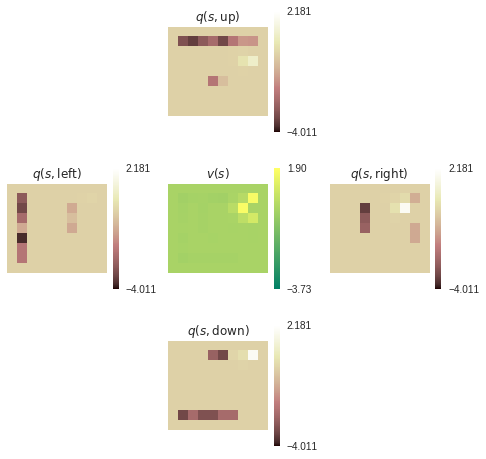

In [0]:
# Online Q
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

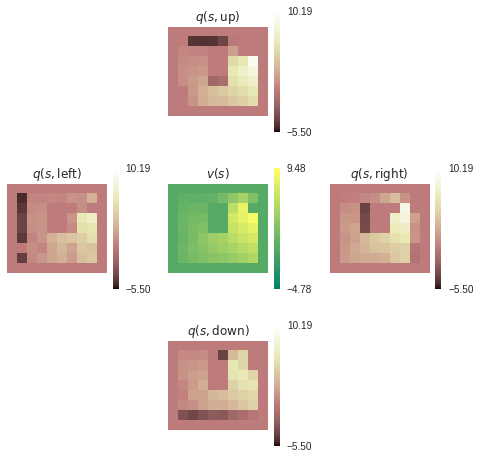

In [0]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

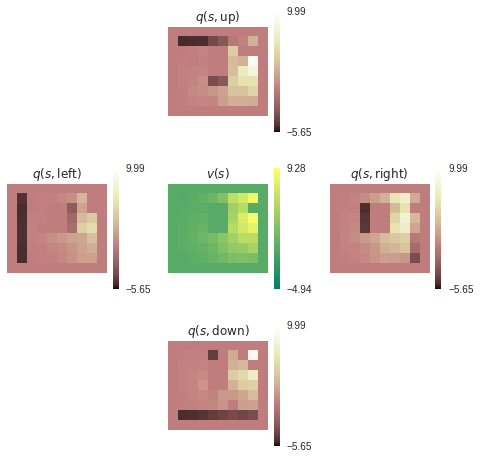

In [0]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Question 2.2.1

**[5 pts]**

In the experiments above, how do the learnt value estimates differ between the online Q-learning, ExperienceReplay, and Dyna Q agents?

Explain meaningful differences in at most 5 sentences.

>- The estimated learnt value estimates of ExperienceReplay agent is much more data efficient than that of online Q-learning. Because ExperienceReplay agent has reduced variance of the updates due to the successive updates are not correlated with one another as they would with standard (online) Q-learning. In online Q-learning $v(s)$ looks constant all but the top right corner.

>- The (tabular) Dyna-Q agent value estimates look different to ExperienceRelay agent (with same number of offline updates) due to how Dyna-Q updates its value using a model based on the latest transition to generate $R, S'$ from $M(S,A)$. Whereas ExperienceReplay is the same as Dyna-Q without the modelling part and I think this justfies why the $v(s)$ looks similar in some ways. Again Dyna-Q is more data-efficient than online-Q agent due to the number of offline updates allowing faster convergence.

>- The value estimates of the online Q-learning agent looks the most different than all other agents, this is because this agent does not incorporate any planning and therefore the action values were equal - this is because each episode adds only one additional step to the policy and so only one step, the last step has been learned so far. 

### Run experiments matching computational cost

*Online Q-learning*

* $\text{number_of_steps}$ = $31,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $1000$ and $\text{num_offline_updates}$ = $30$

*DynaQ*

* $\text{number_of_steps}$ = $1000$ and $\text{num_offline_updates}$ = $30$

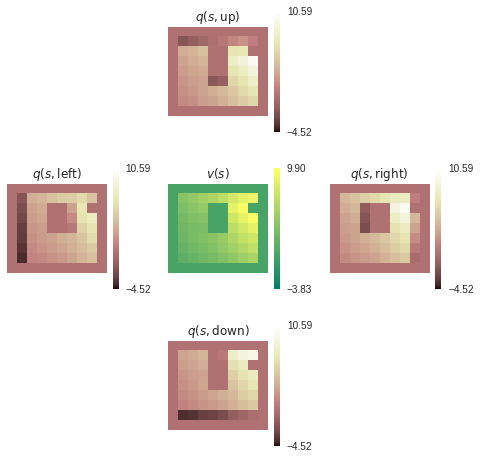

In [0]:
# OnlineQ
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(31e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

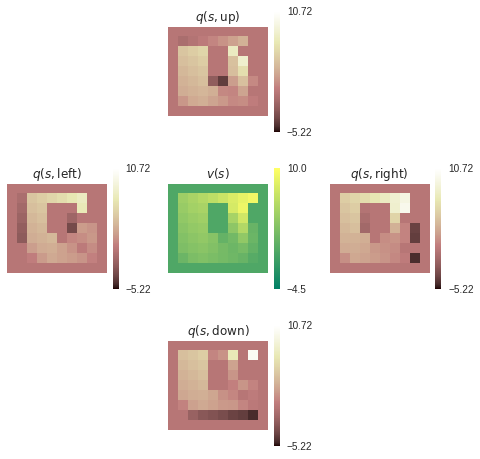

In [0]:
# Experience Replay
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

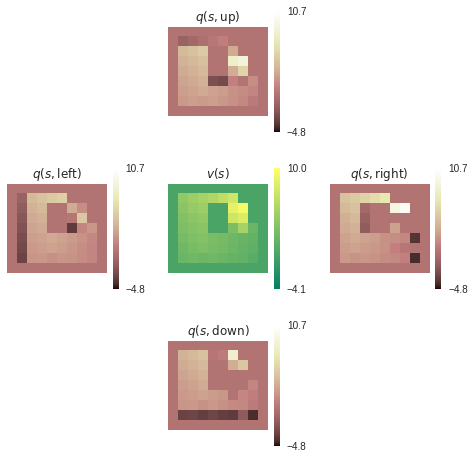

In [0]:
# DynaQ
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### Question 2.2.2

**[5 pts]**

What if sampling from the environment is cheap and we don't care about data efficiency but only care about the amount of computation we use? 

The experiments directly above this question are the same as those above question 2.2.1, except that we ran the experiments for the same number of **total updates**, rather than the same number of **steps in the environment**, therefore using more data for the online Q-learning algorithm which *only* updates from real data.

How do the learnt values, and the relative performances, change, compared the the experiment above question 2.2.1?  Explain in at most 5 sentences.

>- In this case since we do not care about data efficiency, the learnt values for online Q-learning has changed significantly. Online Q-learning performs better when the agent runs more steps and this is because this agent has gathered data from interacting with the real world 

>- When compared to the other agents,  Dyna-Q agent is generating data via a model in it's algorithm which can have some sort of bias. Comparing the ExperienceReplay agent because the number of steps is fixed to $1000$ for both Dyna-Q and ExperienceReplay we can therefore conclude that since online Q-learning has more time-steps the ExperienceReplay agent could have outdated and potentially biased offline updates stored in its buffer (sampling bias).

### Run experiments with linear function approximation

We will now use the $\text{FeatureGrid}$ domain, and consider the same 3 algorithms in the context of linear function approximation.

*Online Q-learning*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{number_of_steps}$ = $100,000$ and $\text{num_offline_updates}$ = $10$

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
/usr/local/lib/python2.7/dist-packages/matplotlib/__init__.py:910: MatplotlibDeprecationWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  mplDeprecation)
/usr/local/lib/python2.7/dist-packages/matplotlib/rcsetup.py:156: MatplotlibDeprecationWarning: axes.hold is deprecated, will be removed in 3.0
  mplDeprecation)


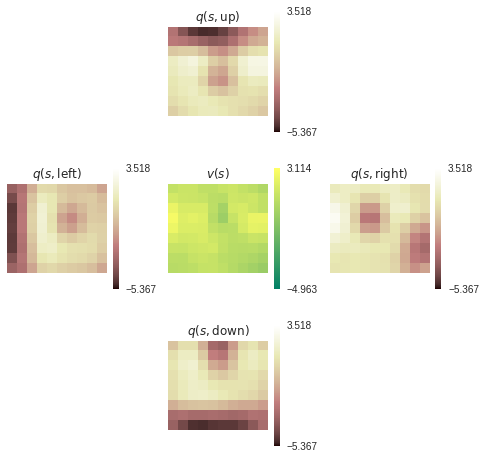

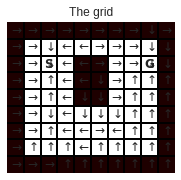

In [0]:
# OnlineQ
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in xrange(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


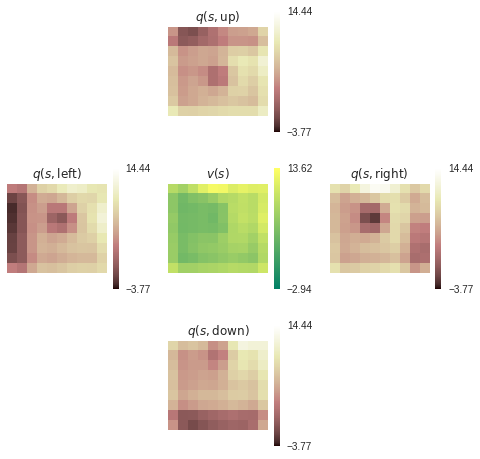

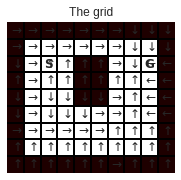

In [0]:
# Experience Replay
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in xrange(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:104: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


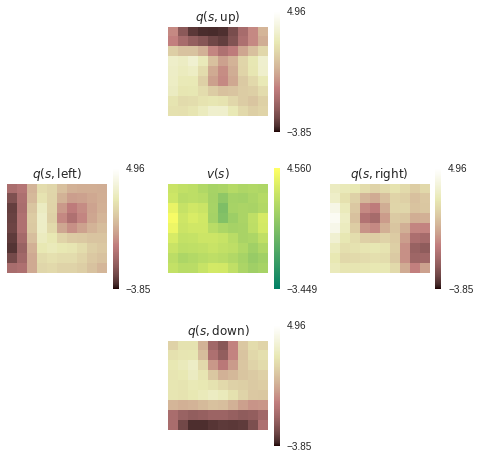

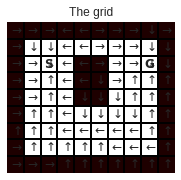

In [0]:
# DynaQ

grid = FeatureGrid()

agent = FeatureDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in xrange(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

### Question 2.2.3

**[5 pts]**

How do the values estimates learnt with function approximation differ from those learnt in the tabular setting, as in the experiment above question 2.2.1?

Explain the results in at most 5 sentences.

>- The charts above that are outputted are significantly blurrier than the tabular setting despite having more time steps. The reason for the differences is because in linear function approximation the state-action pair would update the entire parameters - including all other states - in the agent which will change in the algorithm. Therefore we can see the results of this where the colour/value of $v(s)$ are fairly similar and hence *blurry*.

>- If we look closely at the charts outputted by agents with linear function approximation we can see that the area where there are walls (see the gridworld) are *fairly bright* meaning that we are unable to distinguish a wall from the other states which is a consequence of using linear function approximation.

### Question 2.2.4

**[5 pts]**

Inspect the policies derived by training agents with linear function approximation on `FeatureGrid'. 

How do they compare to the optimal policy?

>- The trivial answer is that all linear function approximation agent(s) are **worse** than the optimal policy. The charts themselves are self-explaining - If we inspect the gridworld we can see that agents get stuck between two states. 

>- An example is on the online Q-learning (near bottom right of wall) then we can see some of the arrows pointing to each other meaning that the agent is moving between the two states.

>- We can also point to the charts of $v(s)$ for the linear function approximation agents when compared to the optimal policy, the areas where the walls are not distinctly defined. Meaning that for unseen states like the walls, their borders are not so clear which may be caused by other states during the update. 

### Run experiments in a non stationary environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left). The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

*Online Q-learning*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$, and $\text{num_offline_updates}$ = $0$

*ExperienceReplay*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

*DynaQ*

* $\text{pretrain_steps}$ = $20,000$,  $\text{num_steps}$ = $666$ and $\text{num_offline_updates}$ = $10$

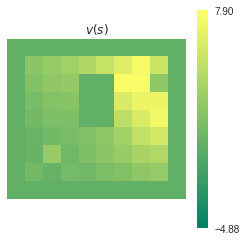

In [0]:
# Online Q

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

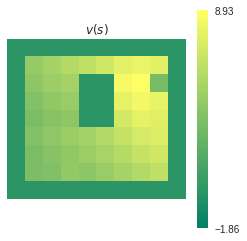

In [0]:
# Experience Replay

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=10, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

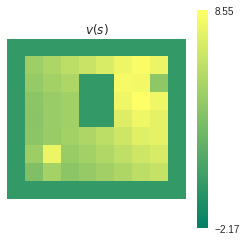

In [0]:
# DynaQ

# Train on first environment
pretrain_steps = 2e4
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=10, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(pretrain_steps / 30))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

### Question 2.2.5

**[5 pts]**

Compare the value estimates of online Q-learning and Dyna-Q, after training also on the new goal location.

Explain what you see in at most 5 sentences. 

> - The Dyna-Q agent seems to find out about the change in goal very quickly since the bottom-left corner is very bright but also the top right corner due to being trained on the original goal. Checking back at the algorithm, since Dyna-Q uses recent observations $S,A$ to generate $R, S'$ to update $Q(S,A)$ values and so the data generated by the model may have picked up changes in the environment. 


>- When comparing to online Q-learning, if we look at the left corner we see 2 $v(s)$ sqaures that are strangely brighter than those around it. That being said, this could mean that the agent begins to find out about the change but still the $v(s)$ is low around that region - therefore if we have more number of steps i think this agent can converge. The reason for this is that because online Q-learning is interacting with the environment with the new goal and the algorithm therefore updates it's $Q$ values in this environment. In this scenario the best performing agent is Dyna-Q


### Question 2.2.6

**[5 pts]**

Compare the value estimates of online Experience Replay and Dyna-Q, after training also on the new goal location, explain what you see.

> - Looking at Experience Replay agent we can see that the value estimate $v(s)$ looks pretty similar to the experiment trained on the original goal. This implies that the agent does not even know about the change in goal? In the algorithm I see a replay buffer where the recent parameters are stored. And so this could mean that the agent can be still dependent on this which we know due to the change in environment that the replay buffer is now outdated and biased towards the original goal which leads to the agent detecting the change slowly.

>- Comparing this to Dyna-Q, we see a completely different story where the bottom left and top right corners are bright implying that the agent has detected the change quickly and again is plausible to conclude that the algorithm has a data generative model to detect the change in goal (mentioned in prev question) to allow for faster convergence, again Dyna-Q is much better than the other agents in performance given the change in environment/goal.

# Part 3: Policy Gradients

## 3.1. Policy Gradients

Consider a simple 2x2 gridworld.

- The agent starts in one of the top cells.
- Both cells on the bottom row are terminal.
- The bottom left cell provides a negative -1 reward.
- The bottom right cell provides a positive +1 reward.
- There is a fixed discount of 0.9


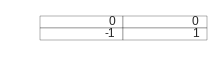

In [0]:
#@title MDP rewards

plt.figure(figsize=(3,0.7))
clust_data = np.array([[0, 0], [-1, 1]])
collabel=("col 1", "col 2", "col 3")
the_table = plt.table(cellText=clust_data, loc='center')
plt.axis('tight')
plt.axis('off')
plt.show()

### Question 3.1.1

**[1 pts]**

What are the *action values*  if the agent can perceive exactly in what state it is?

>- If the agent can percieve exactly what state it is in, then the action values or $Q$ are the following:

>- Suppose we start in the top left (denoted by $L$) state then since this is a deterministic MDP then our Q value is:

$$ Q(L, Right) = \mathbb{E}(R_{t+1} + \gamma\max_{a'}(Q(s',a'))) $$ 

$$ Q(L, Right) = \mathbb{E}(0 + 0.9*1)) = 0.9 $$ 

>- A Q table for each state and action can be formed:

>|Up | Down | Left | Right
>---|---|:---|:---:|---:
>Left State|0|-1|0|0.9
>Right State|0.9|1|0|0.9


### Question 3.1.2

**[4 pts]**

What are the *action values*  if the agent cannot tell whether he is in the right or left column?

>- Where the $\nabla$ operator is the gradient function wrt the parameters (see subscript) and $J(\theta)$ is action-value function. Now we can use the policy gradient theorem to show what the quantity $\nabla_{\theta}J(\theta)$ is.

$$ \nabla_{\theta}J(\theta) = \mathbb{E}_{\pi}( \nabla_{\theta}(\log[\pi_{\theta}(s|a)])Q(s,a)) $$

>- Where $\pi_{\theta}(s|a)$ policy which is differentiable whenever it is non zero. An example policy is that it can be a softmax or Gaussian policy.

>- Here we assume a probability of taking an action under some policy for example (see RL slide 6 for aliased gridworld example), since there are there are 2 actions to take in each state, therefore the total actions are 4 and with equal probability as a start we have the following (we could have taken a softmax policy):

$$ \pi_{\theta} = (\text{Wall to N and W, move S}) =  0.25$$
$$ \pi_{\theta} = (\text{Wall to N and W, move E}) =  0.25$$
$$ \pi_{\theta} = (\text{Wall to N and E, move S}) =  0.25$$
$$ \pi_{\theta} = (\text{Wall to N and E, move W}) =  0.25$$

>- Therefore our action values are the following by applying the policy gradient theorem using the above assumptions:

>|Up | Down | Left | Right
>---|---|:---|:---:|---:
>Left State|0|0.60|0|-0.54
>Right State|-0.54|-0.60|0|-0.54

### Question 3.1.3

**[10 pts]**

What is the optimal policy if the agent cannot tell whether he is in the right or left column??

>- Suppose there exists a probability $p$ moving east and therefore a probability $1-p$ of moving south. Since there is only reward when we take action of "south" and that the *undiscounted* reward will always be at the first step if we go down and subsequent movements and rewards will be discounted. 

>- Suppose we are in the right state, let $X$ denotes the random variable of the agent moving south and applying properties of a geometric series we have the following:

$$ v_{\pi}(\text{Right State}) = \sum_{i} \mathbb{P}(X = i)\gamma^{i-1} =  \sum_{i} p^{i-1}(1-p)\gamma^{i-1} = \frac{1-p}{1-p\gamma}$$

>- Suppose we are in the left state, then if we move south then we receive a reward of $-1$ with probability $1-p$ but if the agent moves east then we are in the situation as if we started in the the right state which is  $v_{\pi}(\text{Right State}) $ because the agent doesn't know where it is! Therefore the following relation holds:

$$ v_{\pi}(\text{Left State}) = -1*(1-p) + \frac{1-p}{1-p\gamma}$$

>- To obtain the optimal policy we apply the policy gradient theorem on $ J(\theta = p) = q*v_{\pi}(\text{Left State}) + (1-q)*v_{\pi}(\text{Right State})$ for some $q$ which tells us the likelihood of starting in a given state.

>- $\nabla_{p}J(p) = q*(\frac{\gamma(\gamma p^{2}-2\gamma + 1)}{(\gamma p - 1)^2}) + (1-q)(\frac{\gamma - 1}{(\gamma p - 1)^2}) $

>- $\nabla_{p}J(p) = 0 $ and solve for $p$ to find the optimal policy.
